In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "z:\Program Files\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "z:\Program Files\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "z:\Program Files\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "z:\Program Files\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "z:

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "z:\Program Files\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "z:\Program Files\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "z:\Program Files\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "z:\Program Files\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "z:

AttributeError: _ARRAY_API not found

In [2]:
df = pd.read_csv('output.csv')
rqst_df = pd.read_csv('send_request_ns.csv')

column_names = df.columns.values

print("Column names:", column_names)
print("Data shape:", df.shape)

column_names_rqst = rqst_df.columns.values

print("Column names:", column_names_rqst)
print("Data shape:", rqst_df.shape)


Column names: ['test_id' 'query_id' 'pre1_ns' 'pre2_ns' 'pre3_ns' 'pre1_fix_ns'
 'post1_ipc_ns' 'post2_ipc_ns' 'post3_ipc_ns' 'post4_ipc_ns'
 'post1_tcp_ns' 'post2_tcp_ns' 'post3_tcp_ns' 'request_counter']
Data shape: (679, 14)
Column names: ['send_request_ns']
Data shape: (196, 1)


In [3]:
df['pre_mean_ns'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].mean(axis=1)
df['pre_median_ns'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].median(axis=1)
df['post_mean_ipc_ns'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].mean(axis=1)
df['post_median_ipc_ns'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].median(axis=1)
df['post_mean_tcp_ns'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].mean(axis=1)
df['post_median_tcp_ns'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].median(axis=1)
print(df['pre_mean_ns'].mean())
print(df['post_mean_ipc_ns'].mean())
print(df['post_mean_tcp_ns'].mean())

send_request_mean = rqst_df['send_request_ns'].mean()
print(send_request_mean)
df['min_overhead'] = df['request_counter'] * send_request_mean
print(df['min_overhead'].head())

df['introduced_overhead'] = df['post_mean_ipc_ns'] - df['pre_mean_ns']


df['unique_id'] = df['test_id'].astype(str) + '-' + df['query_id'].astype(str)
print(df['unique_id'].head())

148519222.12739322
390599886.94918996
406782124.36622477
5357.765306122449
0    8.036648e+04
1    1.216213e+06
2    8.786735e+05
3    4.816631e+06
4    3.214659e+05
Name: min_overhead, dtype: float64
0    1505-1
1    1506-1
2    1506-2
3    1506-3
4    1506-4
Name: unique_id, dtype: object


In [4]:
df_filtered = df[df['query_id'] != 1]

df_ = df#df_filtered

count = (df_['post_mean_tcp_ns'] < df_['pre_mean_ns']).sum()

print(f"Evaluation True for {count} / {len(df_)} queries,")
print(f"Percentage: {count/len(df_)*100:.2f}%")

Evaluation True for 501 / 679 queries,
Percentage: 73.78%


In [5]:
# Create safe copy
df_copy = df.copy()

# Add fastest column using loc and nested np.where()
df_copy.loc[:, 'fastest_mean_ns'] = np.where(
    df_copy['pre_mean_ns'] <= df_copy[['post_mean_ipc_ns', 'post_mean_tcp_ns']].min(axis=1),
    'pre_mean_ns',
    np.where(
        df_copy['post_mean_ipc_ns'] <= df_copy['post_mean_tcp_ns'],
        'post_mean_ipc_ns',
        'post_mean_tcp_ns'
    )
)

# Reassign back to original
df = df_copy
print(df['fastest_mean_ns'].value_counts())

fastest_mean_ns
post_mean_tcp_ns    259
post_mean_ipc_ns    247
pre_mean_ns         173
Name: count, dtype: int64


Total entries: 638
Valid pre_mean_ns values: 638


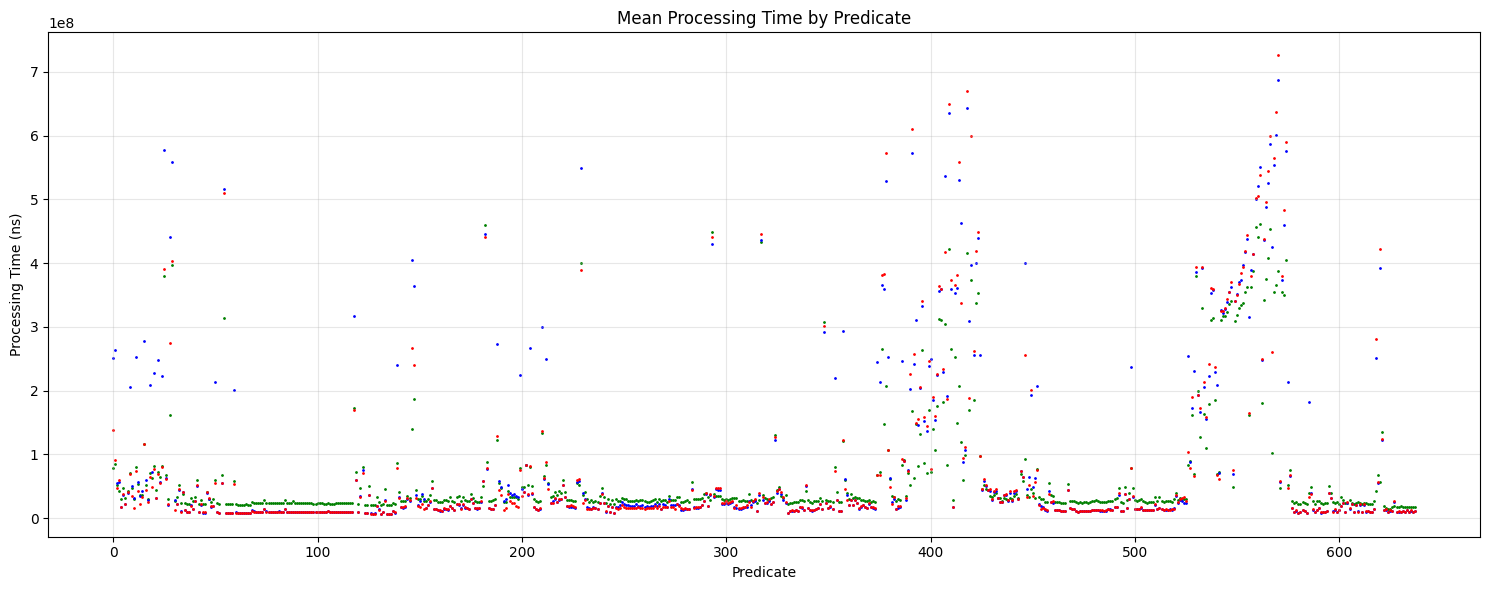

In [13]:
# df_mask = df[(df['pre_mean_ns'] < df['pre_mean_ns'].mean()) & (df['query_id'] != 1)]
quantile = 0.95
df_mask = df[(df['pre_mean_ns'] < df['pre_mean_ns'].quantile(quantile)) & 
    (df['post_mean_ipc_ns'] < df['post_mean_ipc_ns'].quantile(quantile)) & 
    (df['post_mean_tcp_ns'] < df['post_mean_tcp_ns'].quantile(quantile))]# &
    # (df['query_id'] != 1)]

print(f"Total entries: {len(df_mask)}")
print(f"Valid pre_mean_ns values: {df_mask['pre_mean_ns'].count()}")

plt.figure(figsize=(15, 6))

# Create scatter plot without displaying unique_ids
plt.scatter(range(len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1)
plt.scatter(range(len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1)
plt.scatter(range(len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1)
# plt.xticks(range(len(df_mask)), [''] * len(df_mask), rotation=90)
plt.xlabel('Predicate')
plt.ylabel('Processing Time (ns)')
plt.title('Mean Processing Time by Predicate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

(428,)
fastest_mean_ns
post_mean_ipc_ns    221
post_mean_tcp_ns    200
pre_mean_ns           7
Name: count, dtype: int64
26916245.89953271 16495175.227803739 16090157.560747664 93.13084112149532


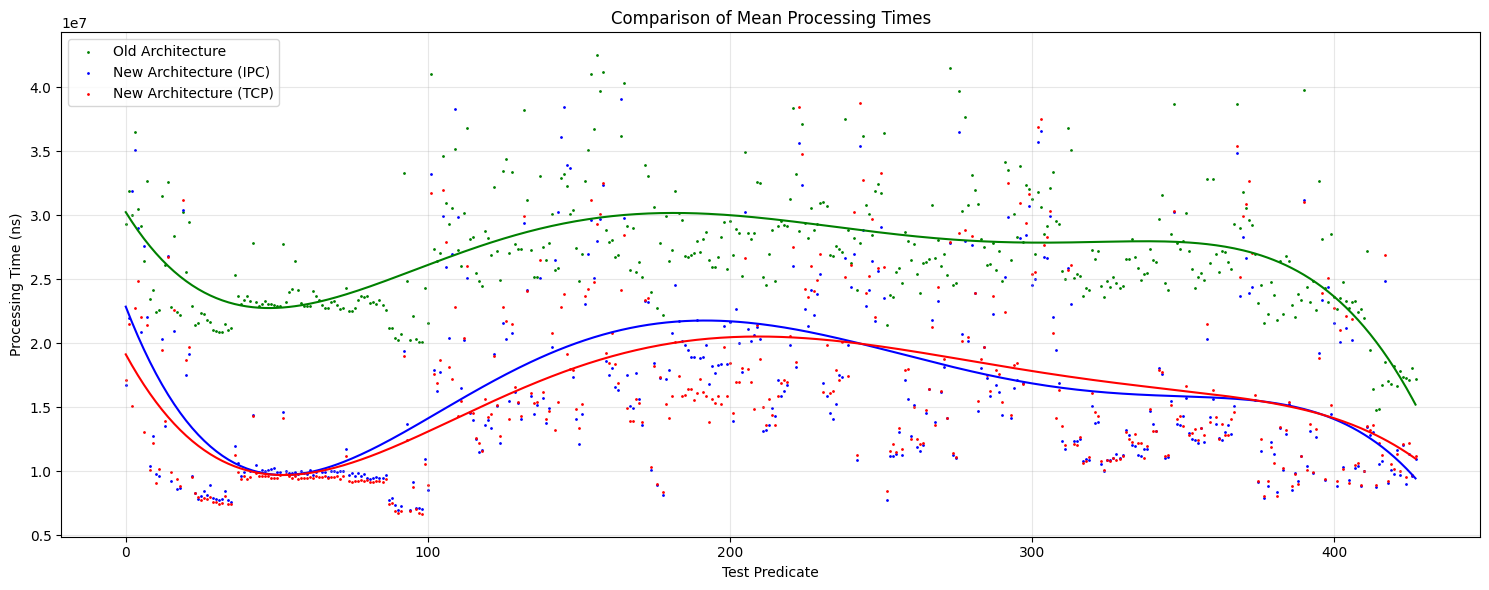

In [7]:
tolerance = 25
quantile = 0.95
df_mask = df#[(df['query_id'] != 1)]

# find the entries, such that at most tolerance entries have pre_mean_ns as fastest mean time
while df_mask['fastest_mean_ns'].value_counts().get('pre_mean_ns', 0) > tolerance:
    x = df_mask['pre_mean_ns'].quantile(quantile)
    df_mask = df[(df['pre_mean_ns'] < x) & 
                 (df['post_mean_ipc_ns'] < x) & 
                 (df['post_mean_tcp_ns'] < x)]


# invert the mask
# df_mask = df[(df['pre_mean_ns'] >= x) & 
#                 (df['post_mean_ipc_ns'] >= x) & 
#                 (df['post_mean_tcp_ns'] >= x)]

# df_mask = df[(df['pre_mean_ns'] < df['post_mean_ipc_ns'])]

# exclude the top 5% of values (extremes)

df_mask = df_mask[(df_mask['pre_mean_ns'] < df_mask['pre_mean_ns'].quantile(quantile)) &
    (df_mask['post_mean_ipc_ns'] < df_mask['post_mean_ipc_ns'].quantile(quantile)) &
    (df_mask['post_mean_tcp_ns'] < df_mask['post_mean_tcp_ns'].quantile(quantile))]


print(df_mask['fastest_mean_ns'].shape)
print(df_mask['fastest_mean_ns'].value_counts())
print(df_mask['pre_mean_ns'].mean(), df_mask['post_mean_ipc_ns'].mean(), df_mask['post_mean_tcp_ns'].mean(), df_mask['request_counter'].mean())

# Plot the data
plt.figure(figsize=(15, 6))
# Create line plots for each mean time
# plt.plot(df_mask.index, df_mask['pre_mean_ns'], color='green', alpha=0.5, label='pre_mean_ns')
# plt.plot(df_mask.index, df_mask['post_mean_ipc_ns'], color='blue', alpha=0.5, label='post_mean_ipc_ns')
# plt.plot(df_mask.index, df_mask['post_mean_tcp_ns'], color='red', alpha=0.5, label='post_mean_tcp_ns')
# Create scatter plots for each mean time
plt.scatter(range(len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
plt.scatter(range(len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
plt.scatter(range(len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')


pre_mean_ns_x = np.arange(len(df_mask['pre_mean_ns']))
pre_mean_ns_y = df_mask['pre_mean_ns'].values
post_mean_ipc_ns_x = np.arange(len(df_mask['post_mean_ipc_ns']))
post_mean_ipc_ns_y = df_mask['post_mean_ipc_ns'].values
post_mean_tcp_ns_x = np.arange(len(df_mask['post_mean_tcp_ns']))
post_mean_tcp_ns_y = df_mask['post_mean_tcp_ns'].values

# Fit polynomial (degree=3 for cubic fit)
pre_mean_ns_coefficients = np.polyfit(pre_mean_ns_x, pre_mean_ns_y, 5)
pre_mean_ns_polynomial = np.poly1d(pre_mean_ns_coefficients)
post_mean_ipc_ns_coefficients = np.polyfit(post_mean_ipc_ns_x, post_mean_ipc_ns_y, 5)
post_mean_ipc_ns_polynomial = np.poly1d(post_mean_ipc_ns_coefficients)
post_mean_tcp_ns_coefficients = np.polyfit(post_mean_tcp_ns_x, post_mean_tcp_ns_y, 5)
post_mean_tcp_ns_polynomial = np.poly1d(post_mean_tcp_ns_coefficients)

# Calculate fitted values
pre_mean_ns_y_fitted = pre_mean_ns_polynomial(pre_mean_ns_x)
post_mean_ipc_ns_y_fitted = post_mean_ipc_ns_polynomial(post_mean_ipc_ns_x)
post_mean_tcp_ns_y_fitted = post_mean_tcp_ns_polynomial(post_mean_tcp_ns_x)

# Add fitted values to dataframe
# df_mask['pre_mean_ns_fitted'] = pre_mean_ns_y_fitted
# df_mask['pre_mean_ns_fitted'] = post_mean_ipc_ns_y_fitted
# df_mask['pre_mean_ns_fitted'] = post_mean_tcp_ns_y_fitted
plt.plot(pre_mean_ns_x, pre_mean_ns_y_fitted, color='green')
plt.plot(post_mean_ipc_ns_x, post_mean_ipc_ns_y_fitted, color='blue')
plt.plot(post_mean_tcp_ns_x, post_mean_tcp_ns_y_fitted, color='red')


# Highlight the fastest mean time
# colors = {'pre_mean_ns': 'green', 'post_mean_ipc_ns': 'blue', 'post_mean_tcp_ns': 'red'}
# for key, group in df_mask.groupby('fastest_mean_ns'):
#     plt.scatter(group.index, group[key], s=10, color=colors[key], label=f'Fastest: {key}', edgecolor='black')

plt.xlabel('Test Predicate')
plt.ylabel('Processing Time (ns)')
plt.title('Comparison of Mean Processing Times')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

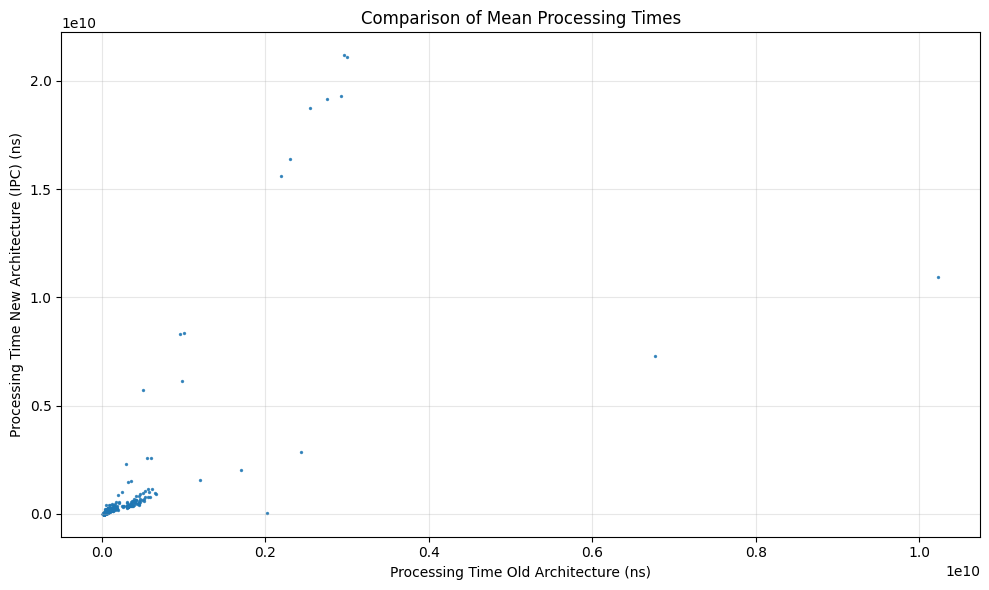

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df['pre_mean_ns'], df['post_mean_ipc_ns'], s=2, alpha=0.8)
plt.xlabel('Processing Time Old Architecture (ns)')
plt.ylabel('Processing Time New Architecture (IPC) (ns)')
plt.title('Comparison of Mean Processing Times')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


679 679


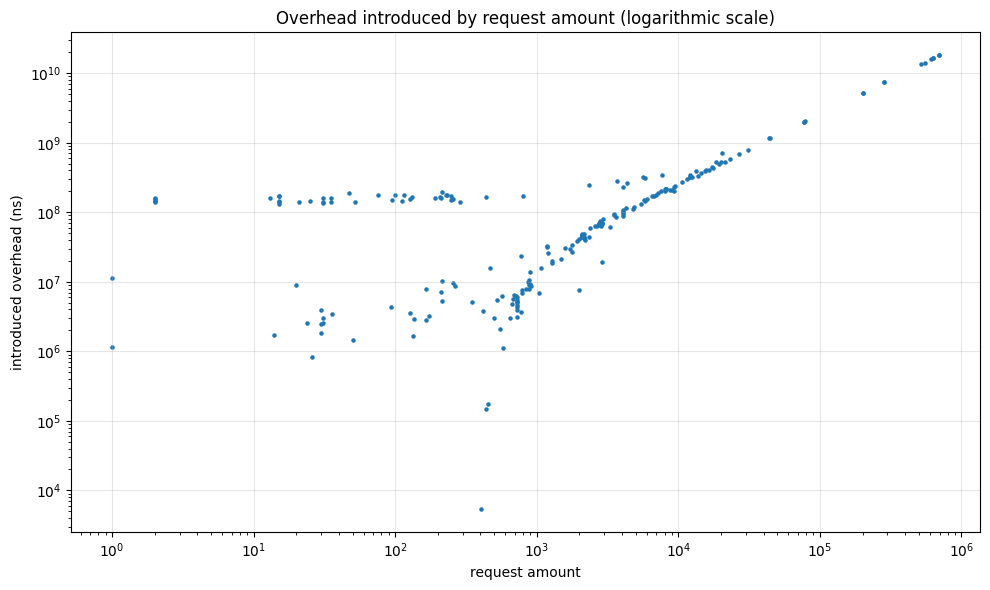

In [9]:

plt.figure(figsize=(10, 6))
plt.scatter(df['request_counter'], df['introduced_overhead'], s=5)
print(len(df['request_counter']), len(df['introduced_overhead']))
x = np.arange(len(df['request_counter']))
y = (df['introduced_overhead']).values

# # Fit polynomial (degree=3 for cubic fit)
# coefficients = np.polyfit(x, y, 1)
# polynomial = np.poly1d(coefficients)

# # Calculate fitted values
# fitted = polynomial(x)

# # Add fitted values to dataframe
# # df_mask['pre_mean_ns_fitted'] = pre_mean_ns_y_fitted
# # df_mask['pre_mean_ns_fitted'] = post_mean_ipc_ns_y_fitted
# # df_mask['pre_mean_ns_fitted'] = post_mean_tcp_ns_y_fitted
# plt.plot(x, fitted, color='green')

plt.xscale('log')  # Apply log scale to x-axis
plt.yscale('log')  # Apply log scale to y-axis if needed
plt.xlabel('request amount')
plt.ylabel('introduced overhead (ns)')
plt.title('Overhead introduced by request amount (logarithmic scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

0    1.729389e+08
1    1.791301e+08
2    2.790885e+06
3    1.403516e+07
4   -1.260360e+07
Name: introduced_overhead, dtype: float64
459


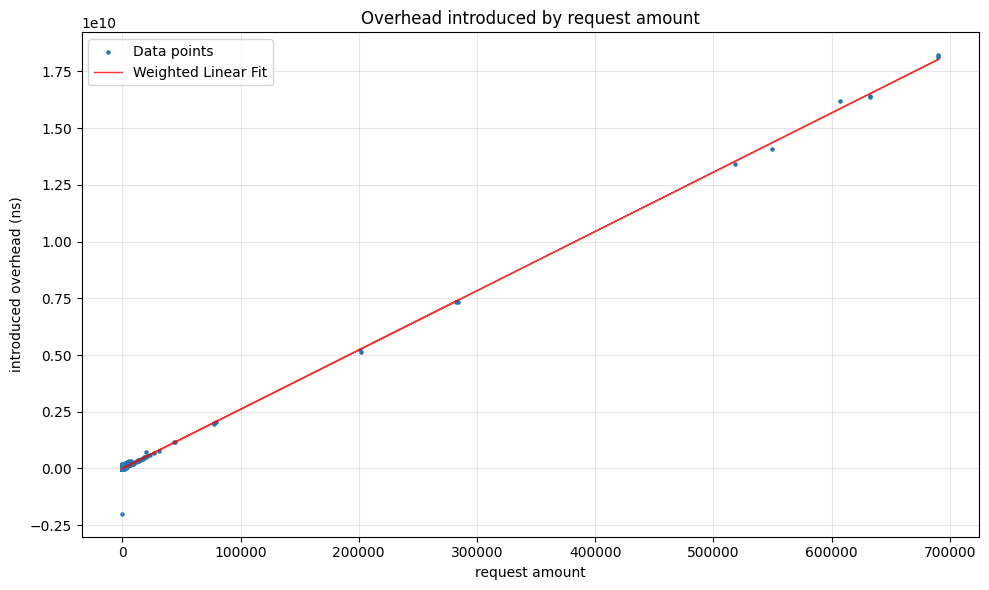

Intercept: -2979499.0507571697
Slope: [26121.01856765]


In [10]:

print(df['introduced_overhead'].head())
print((df['introduced_overhead'] < 0).sum())
# Calculate frequency (clumping points)
try:
    freq = df.groupby(['request_counter', 'introduced_overhead']).size().reset_index(name='count')
    df = pd.merge(df, freq, on=['request_counter', 'introduced_overhead'], how='left')
    df['weight'] = 1 / df['count']
except (KeyError, pd.errors.MergeError) as e:
    pass
# Weights as inverse frequency

# Extract X, y, and weights
X = df['request_counter'].values.reshape(-1, 1)  # Reshape for sklearn
y = df['introduced_overhead'].values
weights = df['weight'].values

# Fit weighted regression
model = LinearRegression()
model.fit(X, y, sample_weight=weights)

# Predict values
y_pred = model.predict(X)

# Plot data and weighted regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['request_counter'], y, s=5, label='Data points')
plt.plot(df['request_counter'], y_pred, color='red', linewidth=1, alpha=0.8, label='Weighted Linear Fit')
plt.xlabel('request amount')
plt.ylabel('introduced overhead (ns)')
plt.title('Overhead introduced by request amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_)